Press Enter to start recording
Recording...
Finished recording.


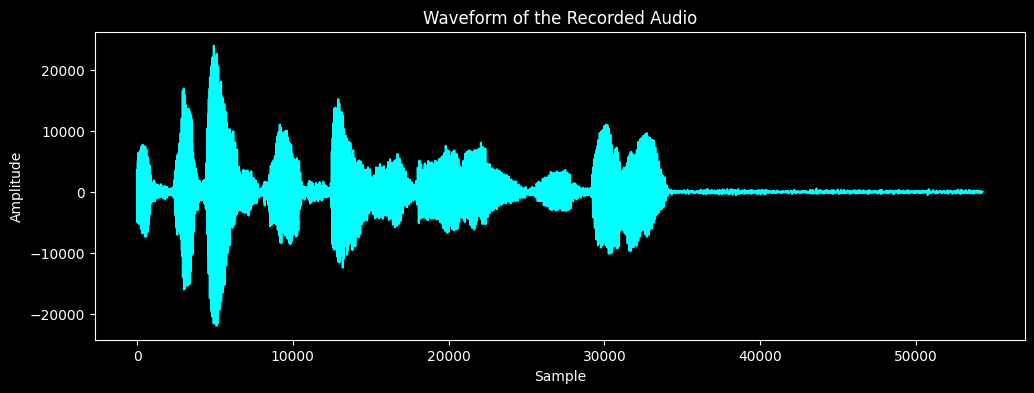

In [7]:
import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
from array import array
from sys import byteorder

# Constants for audio recording
FORMAT = pyaudio.paInt16  # 16-bit resolution
CHANNELS = 1  # Mono
RATE = 16000  # Sample rate
CHUNK_SIZE = 1024  # Frame size
WAVE_OUTPUT_FILENAME = "speech.wav"

# New buffer variables
SILENCE_THRESHOLD = 20  # number of continuous silent chunks to consider as the end of speech
silent_chunks = 0  # counter for silent chunks

# Initialize PyAudio object
p = pyaudio.PyAudio()

# Function to calculate the energy per sample in decibels
def EnergyPerSampleInDecibel(frame):
    data_int = array('h', frame)
    if byteorder == 'big':
        data_int.byteswap()
    energy = sum(abs(sample) for sample in data_int) / max(len(data_int), 1)
    energy = max(energy, 1e-7)  # Avoid log of zero
    decibels = 10 * np.log10(energy)
    return decibels

# Adaptive endpointing function
def classifyFrame(current, level, forgetfactor, adjustment, threshold, background):
    isSpeech = False
    level = ((level * forgetfactor) + current) / (forgetfactor + 1)
    
    if current < background:
        background = current
    else:
        background += (current - background) * adjustment
        
    if level < background:
        level = background
        
    if (level - background) > threshold:
        isSpeech = True
        
    return isSpeech, level, background

# Placeholder variables for the adaptive endpointing algorithm
forgetfactor = 1.0  # To be tuned
adjustment = 0.05  # To be tuned
threshold = 5  # To be tuned, in decibels
level = 0  # Initial level will be set by the first frame
background = 50  # Initially high to ensure speech is detected over it

print("Press Enter to start recording")
input()  # This will wait until the Enter key is pressed

# Start the audio stream
stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK_SIZE)

# Initialize recording loop
frames = []
isRecording = False  # Flag to start recording when speech is detected
print("Recording...")

while True:
    data = stream.read(CHUNK_SIZE, exception_on_overflow=False)
    current = EnergyPerSampleInDecibel(data)
    
    # Only start classifying after the first frame
    if level == 0:
        level = current
        background = current
    
    isSpeech, level, background = classifyFrame(current, level, forgetfactor, adjustment, threshold, background)
    
    if isSpeech:
        isRecording = True
        silent_chunks = 0  # reset the silent_chunks counter as we've detected speech
    else:
        if isRecording:
            # If we've started recording and encounter silence, increment the counter
            silent_chunks += 1
            # If we've hit the silence threshold, consider it the end of speech
            if silent_chunks > SILENCE_THRESHOLD:
                break
    
    if isRecording:
        frames.append(data)

print("Finished recording.")
    
    

# Stop and close the stream
stream.stop_stream()
stream.close()
p.terminate()

# Save the recorded frames as a WAV file
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

plt.style.use('dark_background')  # Set the background theme

# Plotting the waveform
signal = np.frombuffer(b''.join(frames), dtype=np.int16)
plt.figure(figsize=(12, 4))
plt.plot(signal, color = 'cyan')
plt.title('Waveform of the Recorded Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.savefig('waveform.png')  # Save the plot as a PNG file
plt.show()
